# Comparative Study of Image Processing Algorithms to Detect Defects in Cast Components

### Author: Nikith Muralidhar (10586165)

#### Abstract:

In the manufacturing industry, non-destructive evaluation (NDE) of components is crucial.
These cast components are susceptible to blowholes and other anomalies.
If such flaws are included into the components, the fatigue life will be harmed, which would almost certainly result in catastrophic accidents. Humans currently evaluate cast components by various methods.
We propose an automatic approach for detecting faults in casts with the goal of
producing a category that will eliminate the need for manual testing. The technique looks for defects in cast components, In the previous years, Image processing technology has advanced significantly. The method proposed utilises  Convolutional Neural Networks (CNN) and Support Vector Classifiers (SVC's). This process classifies if the component has a defect or not. Human examiners may benefit from the approach because it reduces their workload, according to the hypothesis.

### 1. Importing Packages 

In [1]:
from PIL import Image
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.metrics
import keras
import cv2
import warnings
warnings.filterwarnings('ignore')

### 2. Reading and Displaying the image data

Text(0.5, 1.0, 'defective')

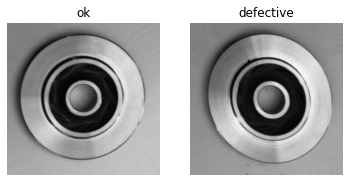

In [2]:
dataset_path = os.getcwd() + '/casting_data'

train_ok_dir = dataset_path + '/train/ok_front/'
train_def_dir = dataset_path + '/train/def_front/'

i1 = plt.imread(train_ok_dir + random.choice(os.listdir(train_ok_dir)))
i2 = plt.imread(train_def_dir + random.choice(os.listdir(train_def_dir)))

fig, ax = plt.subplots(1, 2)

ax[0].imshow(i1)
ax[0].axis('off')
ax[0].set_title('ok')

ax[1].imshow(i2)
ax[1].axis('off')
ax[1].set_title('defective')

### 3. Data Augmentation


Creating variaitions of our dataset. This would include rescaling, increasing/decreasing the height and width. Zooming in and out and flipping the image.

In [4]:
def create_generators():

    data_gen = keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                            validation_split = 0.1,
                                                            rotation_range=10,
                                                            width_shift_range=0.1, 
                                                            height_shift_range=0.1,
                                                            shear_range=0.15, 
                                                            zoom_range=0.1,
                                                            channel_shift_range=10,
                                                            horizontal_flip=True
                                                           )
    
    train_generator = data_gen.flow_from_directory(directory = dataset_path + '/train', 
                                                  batch_size = 32,
                                                  target_size = (300, 300),
                                                  color_mode = "grayscale",
                                                  class_mode = "binary",
                                                  classes = {"ok_front": 0, "def_front": 1},
                                                  shuffle = True,
                                                  subset = "training")

    val_generator = data_gen.flow_from_directory(directory = dataset_path + '/train',
                                                       batch_size = 32,
                                                       target_size = (300, 300),
                                                       color_mode = "grayscale",
                                                       class_mode = "binary",
                                                       classes = {"ok_front": 0, "def_front": 1},
                                                       shuffle = True,
                                                       subset = "validation")
    
    return train_generator, val_generator

In [5]:
train_generator, val_generator = create_generators()

Found 5971 images belonging to 2 classes.
Found 662 images belonging to 2 classes.


In [28]:
test_datagen =  keras.preprocessing.image.ImageDataGenerator(rescale = 1/255,
                                                            validation_split = 0.1,
                                                            rotation_range=10,
                                                            width_shift_range=0.1, 
                                                            height_shift_range=0.1,
                                                            shear_range=0.15, 
                                                            zoom_range=0.1,
                                                            channel_shift_range=10,
                                                            horizontal_flip=True)

n_test = sum([len(files) for r, d, files in os.walk(dataset_path + '/test')])

test_generator = test_datagen.flow_from_directory(directory = dataset_path + '/test',
                                                  batch_size = n_test,
                                                  target_size = (300, 300),
                                                  color_mode = "grayscale",
                                                  class_mode = "binary",
                                                  classes = {"ok_front": 0, "def_front": 1},
                                                  shuffle = False)

Found 715 images belonging to 2 classes.


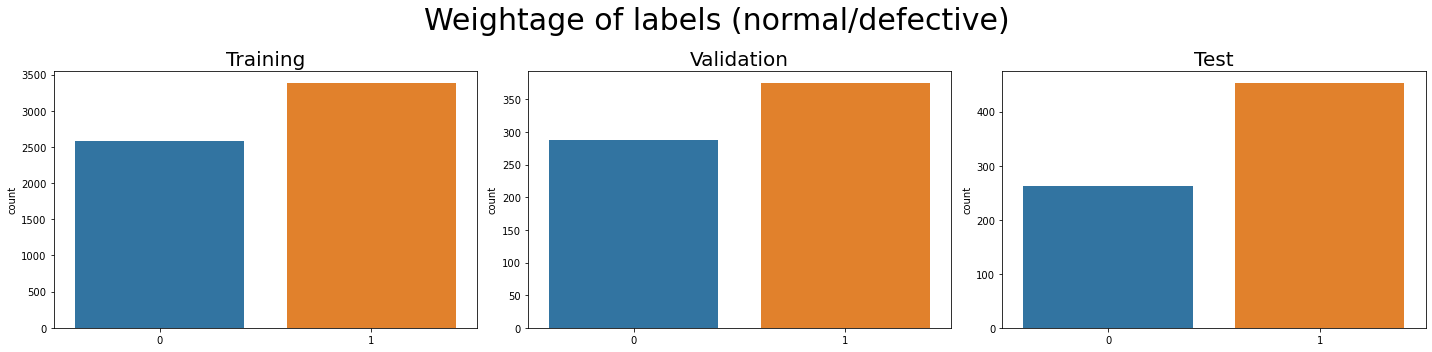

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

sns.countplot(train_generator.classes, ax=ax[0])
sns.countplot(val_generator.classes, ax=ax[1])
sns.countplot(test_generator.classes, ax=ax[2])

ax[0].set_title('Training', fontsize=20)
ax[1].set_title('Validation', fontsize=20)
ax[2].set_title('Test', fontsize=20)

fig.suptitle('Weightage of labels (normal/defective)', fontsize=30)
fig.tight_layout(rect=[0, 0.01, 1, 1])

In [8]:
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Input, Activation
from tensorflow.keras.layers import Conv2D, Dropout, Reshape, Lambda, Flatten
from tensorflow.keras.layers import GaussianDropout, GaussianNoise
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import BatchNormalization as BatchNorm
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import Sequence

import matplotlib as mplot
import matplotlib.pyplot as plt

import numpy as np

from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor

Process of the convolutional network
- an image should be represented as a tensor to feed to the network. The resulting tensor has a 15 x 20 x 3 shape(there are 15 rows, 20 columns and 3 color channels).
- Then the image goes through a convolutional layer. A filter (also called a "kernel"), usually size 3x3 (commonly used), 5x5 or 7x7, runs through the pixels of an image computing the dot product at each step in the convolution operation and storing the results in a matrix called "feature map".
- The feature map is the structure responsible for recognizing the various patterns (features) related to the image.
- The feature map coming from the filter is the sum of the feature maps collective to each channel. Several filters, each corresponding to a feature map.
- each filter of a layer is a parameter of the network, it is adjusted with the weights to result in the optimal learning. Multiple feature maps are fed to a new convolutional layer.
- same padding is choosen so zeros are added to the edges of the input map so that the output map has the same shape as the input.
- strides are used to make output maps smaller than the input ones.
- The pooling layers reduce the number of network parameters, attenuating overfitting and computational cost.
- First few layers performs feature extraction and pattern identification in images. And rest works on classification.



### 4. Building CNN model

In [28]:
def build_cnn_model():
    model = keras.models.Sequential([

    keras.layers.Conv2D(filters=16, kernel_size=(7,7), strides = 2, activation="relu", 
                        padding="same", input_shape=(300, 300, 1)),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
        
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
        
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation="relu", padding="same"),
    keras.layers.MaxPooling2D(pool_size = (2,2), strides = 2),
                
    keras.layers.Flatten(),
    keras.layers.Dense(units=64, activation="relu"),

    keras.layers.Dropout(0.2),

    keras.layers.Dense(units=1, activation="sigmoid")

    ])
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model


We are using kernal size of (7x7) and 2 strides. In the second convolution layer we are using (3x3) kernal size with 2 strides with relu as the activation function and the same is followed till the last convolution layer. 


In [29]:
build_cnn_model().summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 150, 150, 16)      800       
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 75, 75, 16)       0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 75, 75, 32)        4640      
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 37, 37, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 37, 37, 64)        18496     
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 18, 18, 64)      

In [30]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-6, patience=5)

In [31]:
# checkpoint to save the best model for the network
checkpoint = keras.callbacks.ModelCheckpoint("cnn_model.hdf5",
                                             save_best_only=True,
                                             monitor="val_loss")

In [32]:
cnn_model = build_cnn_model()
results = cnn_model.fit_generator(train_generator,
                                  validation_data=val_generator, 
                                  epochs=100,
                                  callbacks=[early_stop, checkpoint])


Epoch 1/100
187/187 [==============================] - 126s 670ms/step - loss: 0.6868 - accuracy: 0.5636 - val_loss: 0.6833 - val_accuracy: 0.5665
Epoch 2/100
187/187 [==============================] - 141s 755ms/step - loss: 0.6694 - accuracy: 0.5743 - val_loss: 0.6755 - val_accuracy: 0.5801
Epoch 3/100
187/187 [==============================] - 141s 756ms/step - loss: 0.5292 - accuracy: 0.7180 - val_loss: 0.4785 - val_accuracy: 0.7810
Epoch 4/100
187/187 [==============================] - 139s 742ms/step - loss: 0.3994 - accuracy: 0.8149 - val_loss: 0.3175 - val_accuracy: 0.8625
Epoch 5/100
187/187 [==============================] - 147s 788ms/step - loss: 0.2894 - accuracy: 0.8715 - val_loss: 0.3198 - val_accuracy: 0.8520
Epoch 6/100
187/187 [==============================] - 156s 836ms/step - loss: 0.2108 - accuracy: 0.9137 - val_loss: 0.1659 - val_accuracy: 0.9366
Epoch 7/100
187/187 [==============================] - 156s 835ms/step - loss: 0.1827 - accuracy: 0.9263 - val_loss: 0

In [33]:
import pandas as pd
losses = pd.DataFrame(cnn_model.history.history)

<AxesSubplot:>

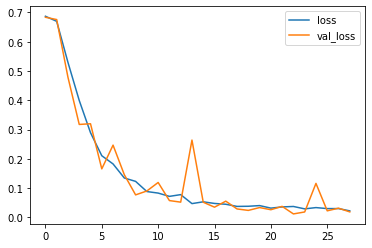

In [34]:
losses[['loss','val_loss']].plot()

<AxesSubplot:>

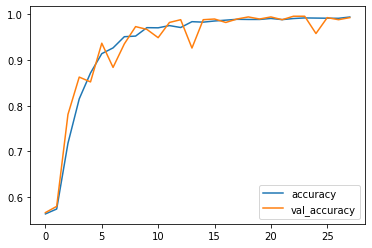

In [35]:
losses[['accuracy','val_accuracy']].plot()

In [14]:
from sklearn.metrics import classification_report, confusion_matrix

In [41]:
# finding predict probability
y = test_generator.classes
y_probs = cnn_model.predict_generator(test_generator)

y_pred_cnn = y_probs > 0.5

print(classification_report(test_generator.classes, y_pred_cnn))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98       262
           1       1.00      0.98      0.99       453

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



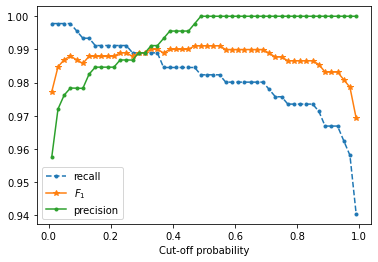

In [43]:
prob_x = np.linspace(0.01,0.99)

recall = [0]*len(prob_x)
f1 = [0]*len(prob_x)
precision = [0]*len(prob_x)

for i in range(len(prob_x)):
    y_pred_rp_curve = y_probs > prob_x[i]
    recall[i] = sklearn.metrics.recall_score(y, y_pred_rp_curve)
    f1[i] = sklearn.metrics.f1_score(y, y_pred_rp_curve)
    precision[i] = sklearn.metrics.precision_score(y, y_pred_rp_curve)

plt.plot(prob_x, recall,'.--')
plt.plot(prob_x, f1,'*-')
plt.plot(prob_x, precision,'.-')

plt.xlabel('Cut-off probability')
plt.legend(['recall','$F_1$','precision'])

In [24]:
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

In [27]:
# load the model we saved
cnn_model = load_model('cnn_model.hdf5')
cnn_model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [43]:
def Prediction(image_path, model):    
    img = image.load_img(image_path, target_size=(300, 300), color_mode = "grayscale")
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    predicted = model.predict(images, batch_size=10)
    classes = np.argmax(predicted, axis=1)
    pred = classes[0]
    
    if (pred==1):
        result = 'ok_front'
    else:
        result = 'def_front'
    
    return result

In [46]:
files = ['def_front', 'ok_front']
test_address = dataset_path + "/test/{}"
data_test = {}
for f in files:
    data_test[f]=[]
for col in files:
    os.chdir(test_address.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpeg'):
            data_test[col].append(i)

1/1 [==============================] - 0s 28ms/step


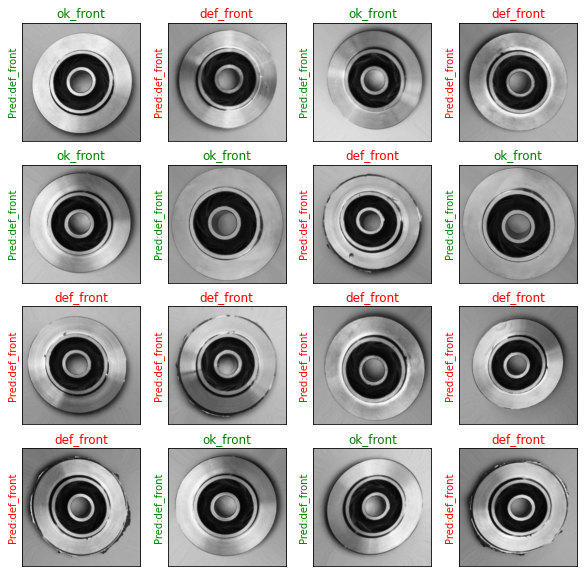

In [52]:
# predicting images
plt.figure(figsize=(10,10))
for i in range(1,17):
    front = np.random.choice(['def_front', 'ok_front'])
    sample = np.random.choice(np.arange(1,200))
    os.chdir(dataset_path + '/test/{}'.format(front))
    img = cv2.imread(data_test[front][sample], 0)
    plt.subplot(4, 4, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if front == 'ok_front':
        c = 'green'
    else:
        c = 'red'
    plt.title(front, color=c)
    plt.ylabel("Pred:{}".format(Prediction(data_test[front][sample], cnn_model)), color=c)
    
plt.show()

### 5. Creating SVC model

In [3]:
files = ['def_front', 'ok_front']
train_address = dataset_path + "/train/{}"
data_train = {}
for f in files:
    data_train[f]=[]
for col in files:
    os.chdir(train_address.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpeg'):
            data_train[col].append(i)
            
test_address = dataset_path + "/test/{}"
data_test = {}
for f in files:
    data_test[f]=[]
for col in files:
    os.chdir(test_address.format(col))
    for i in os.listdir(os.getcwd()):
        if i.endswith('.jpeg'):
            data_test[col].append(i)

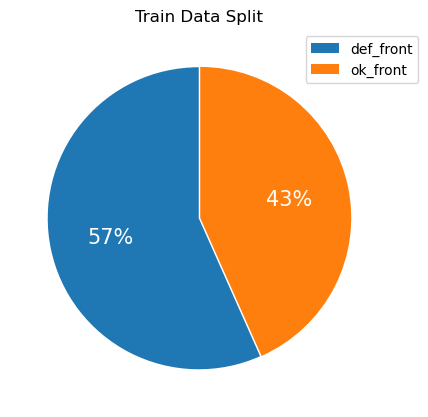

In [4]:
sizes = [len(data_train['def_front']), len(data_train['ok_front'])]

plt.figure(figsize=(10,5), dpi=100)

plt.pie(x=sizes, autopct='%1.0f%%', shadow=False, textprops={'color':"w","fontsize":15}, startangle=90, explode=(0,.01))
plt.legend(files, bbox_to_anchor=(0.4, 0, .7, 1))
plt.title("Train Data Split")
plt.show()

In [5]:
import cv2
from IPython.display import clear_output 

image_data_train = []
image_target_train = []

for title in files:
    os.chdir(dataset_path + '/train/{}'.format(title))
    counter = 0
    for i in data_train[title]:
        img = cv2.imread(i,0)
        image_data_train.append(cv2.resize(img, (15, 15)).flatten())
        image_target_train.append(title)
        counter += 1
        if counter == 3000:
            break
    clear_output(wait=True)
    print("Compiled Class",title)

Compiled Class ok_front


In [6]:
image_data_test = []
image_target_test = []

for title in files:
    os.chdir(dataset_path + '/test/{}'.format(title))
    counter = 0
    for i in data_test[title]:
        img = cv2.imread(i,0)
        image_data_test.append(cv2.resize(img, (15, 15)).flatten())
        image_target_test.append(title)
        counter += 1
        if counter == 3000:
            break
    clear_output(wait=True)
    print("Compiled Class",title)

Compiled Class ok_front


In [7]:
image_data_train = np.array(image_data_train)
size_train = image_data_train.shape[0]
image_data_train.shape

image_data_test = np.array(image_data_test)
size_test = image_data_test.shape[0]
image_data_test.shape

(715, 225)

In [8]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, plot_confusion_matrix, plot_roc_curve 

labels = LabelEncoder()
labels.fit(image_target_train)

LabelEncoder()

In [9]:
train_images = image_data_train / 255.0
test_images = image_data_test / 255.0

train_labels = labels.transform(image_target_train)
test_labels = labels.transform(image_target_test)

In [45]:
svc_model = SVC()
svc_model.C = 100
svc_model.fit(train_images, train_labels)

y_pred_svc = svc_model.predict(test_images)

print(classification_report(test_labels, y_pred_svc))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       453
           1       0.97      1.00      0.98       262

    accuracy                           0.99       715
   macro avg       0.99      0.99      0.99       715
weighted avg       0.99      0.99      0.99       715



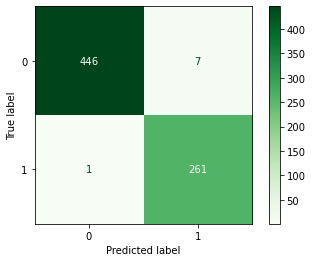

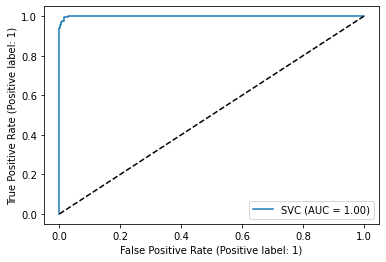

In [16]:
plot_confusion_matrix(svc_model, test_images, test_labels, cmap='Greens')
plt.show()

plot_roc_curve(svc_model, test_images, test_labels)
plt.plot([0,1],[0,1],'k--')
plt.show()

SVC roc curve has large AUC which indicates good performance of the model.

In [12]:
def Prediction(image, model):    
    img = cv2.imread(image,0)
    img = cv2.resize(img,(15, 15)).flatten() / 255.0
    
    pred = model.predict([img])
    
    if (pred==1):
        result = 'ok_front'
    else:
        result = 'def_front'
    
    return result

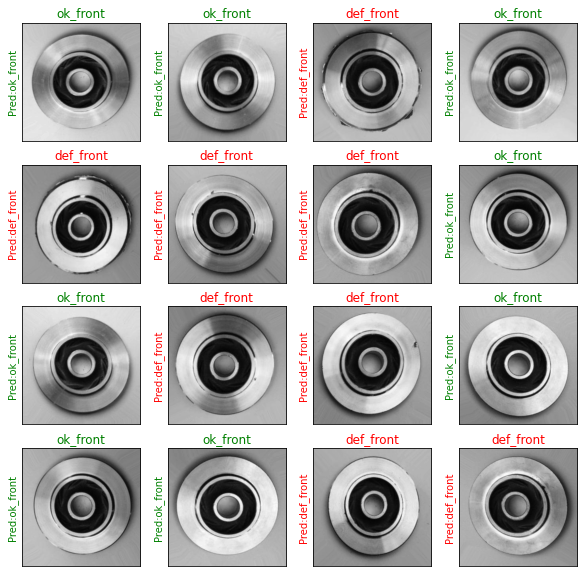

In [68]:
plt.figure(figsize=(10,10))
for i in range(1,17):
    front = np.random.choice(['def_front', 'ok_front'])
    sample = np.random.choice(np.arange(1,200))
    os.chdir(dataset_path + '/test/{}'.format(front))
    img = cv2.imread(data_test[front][sample], 0)
    plt.subplot(4, 4, i)
    plt.imshow(img, cmap='gray')
    plt.xticks([])
    plt.yticks([])
    if front == 'ok_front':
        c = 'green'
    else:
        c = 'red'
    plt.title(front, color=c)
    plt.ylabel("Pred:{}".format(Prediction(data_test[front][sample], svc_model)), color=c)
    
plt.show()

### 6. Model Comparison

In [50]:
import pandas as pd

cnn_scores = classification_report(test_generator.classes, y_pred, output_dict=True)
svc_scores = classification_report(test_labels, y_pred_svc, output_dict=True)

cnn_df = pd.DataFrame(cnn_scores).transpose()
cnn_df.index.name = "Metrics"
svc_df = pd.DataFrame(svc_scores).transpose()
svc_df.index.name = "Metrics"

In [52]:
cnn_df.compare(svc_df, keep_shape=True, keep_equal=True).rename(columns={'self': 'CNN', 'other': 'SVC'}, level=-1)

precision              recall            f1-score            \
                   CNN       SVC       CNN       SVC       CNN       SVC   
Metrics                                                                    
0             0.996198  0.997763  1.000000  0.984547  0.998095  0.991111   
1             1.000000  0.973881  0.997792  0.996183  0.998895  0.984906   
accuracy      0.998601  0.988811  0.998601  0.988811  0.998601  0.988811   
macro avg     0.998099  0.985822  0.998896  0.990365  0.998495  0.988008   
weighted avg  0.998607  0.989012  0.998601  0.988811  0.998602  0.988837   

                 support              
                     CNN         SVC  
Metrics                               
0             262.000000  453.000000  
1             453.000000  262.000000  
accuracy        0.998601    0.988811  
macro avg     715.000000  715.000000  
weighted avg  715.000000  715.000000

# Model Deployment

In [1]:
import keras
import cv2
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

1/1 [==============================] - 0s 94ms/step
[[0.]]
Component is not defective!


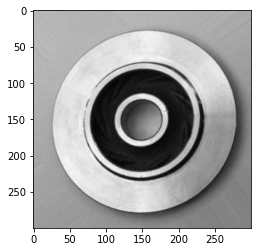

In [2]:
# prediction on the uploaded image
path =  r'C:\Users\Nikith\Desktop\casting_cnn_svc_new\casting_data\casting_data\test\ok_front\cast_ok_0_5533.jpeg'
img = image.load_img(path,  target_size=(300, 300), color_mode = "grayscale") 

# scaling process
x = keras.utils.img_to_array(img)
img = cv2.imread(path, 0)
plt.imshow(x, cmap='gray')
x = np.expand_dims(x, axis=0)

# flatten the output
images = np.vstack([x])

# prediction!
cnn_model = load_model('cnn_model.hdf5')   #Calling the saved model
classes = cnn_model.predict(images, batch_size=10)
print(classes)
if classes[0][0] > 0.5:
    print("WARNING!: Component is Defective")
else:
    print ("Component is not defective!")

1/1 [==============================] - 0s 62ms/step
[[1.]]


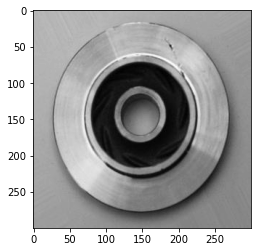

In [3]:
# prediction on the uploaded image
path = r'C:\Users\Nikith\Desktop\casting_cnn_svc_new\casting_data\casting_data\test\def_front\cast_def_0_7.jpeg'
img = image.load_img(path,  target_size=(300, 300), color_mode = "grayscale") # let's use load_img to scale it 

# scaling process
x = keras.utils.img_to_array(img)
img = cv2.imread(path, 0)
plt.imshow(x, cmap='gray')
x = np.expand_dims(x, axis=0)
# flatten the output
images = np.vstack([x])

# prediction!
cnn_model = load_model('cnn_model.hdf5')
classes = cnn_model.predict(images, batch_size=10)
print(classes)
if classes[0][0] > 0.5:
    print("WARNING: Component is Defective")
else:
    print ("Component is not defective!")

## Conclusion

SVM and CNN models' classification performance was contrasted. The suggested model outperforms the other technique in the categorization of datasets, according to the total accuracy of the methods. According to the results in the below table, CNN has the maximum classification accuracy for the dataset. The SVM model just uses the spectral signature of each picture pixel and does not make use of the dataset's rich spatial information. The classification accuracy of the techniques for classifying defects is enhanced by the use of additional spatial information derived from nearby pixels. CNN uses rich spatial characteristics at various scales to represent the spatial structure of the data in order to categorize each pixel in the image since spatial information can increase classification accuracy.
	
Having a high precision rate means the classifiers are working as they should. A high fractional value of recall denotes the recovery of a sizable share of the total number of pertinent occurrences. It's interesting to see that while SVC's accuracy is lower at 98.88%, CNN's accuracy is greater at 99.86%. Determining the discriminative capacity of risk models requires consideration of the precision, recall, and accuracy values. CNN should thus be chosen in this case rather than SVC.